In [1]:
import os
import time
import random
import numpy as np

import yaml    

from scipy.stats import ortho_group

from typing import Optional, Tuple


import torch
import torch.nn as nn
from torch.linalg import norm 
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

# torch.set_default_dtype(torch.float64)

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, is_undirected , to_undirected, contains_self_loops , to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
# from torch_scatter import scatter
# from torch_cluster import knn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import uproot
import vector
vector.register_awkward()
import awkward as ak

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.6.0
PyG version 2.6.1


In [2]:
from TrackML.Preprocessing import process_event_data , process_particle_labels , load_detector_data 

In [3]:
with open('03-Embedding-Hyperparameters.yml' , 'r' ) as f : 
    hparams = yaml.safe_load( f )

In [4]:
hparams 

{'detector_path': '../data/detectors.csv',
 'dataset_path': '../data/train_100_events/',
 'min_hits': 3,
 'shuffle': True,
 'valid_size': 0.1,
 'test_size': 0.1,
 'num_works': 8,
 'in_featuers': 15,
 'hidden_featuers': [1024, 512, 256, 128, 64, 32, 16],
 'out_featuers': 5,
 'margin': 0.1,
 'max_num_neighbours': 100,
 'lr': 0.01,
 'save_model': True,
 'save_model_path': '../data/models/embedding_model.pt'}

#### Pick a random Event for analysis : 

In [5]:
# path to all the csv files : 
train_path = '../data/train_100_events/'

# get a list of all event ids: 
event_ids = [code[:-9] for code in os.listdir(train_path) if code.endswith('-hits.csv') ] 
# number of events : 
nevent = len(event_ids)
print(f'total number of events: {nevent}')

# pick a random event : 
idx = random.randint(0,nevent-1)
eventid = event_ids[idx]
print(f"chosen event : {eventid}")

total number of events: 100
chosen event : event000001057


In [6]:
detector = load_detector_data(hparams['detector_path'])

In [7]:
event_data = process_event_data(
    train_path , eventid ,
    detector , return_dataframe= True 
)

display(event_data )
event_data.shape 

,hit_id,r,sphi,cphi,z,ncells,tvalue,lu,lv,lw,ltheta,lsphi,lcphi,gtheta,gsphi,gcphi
0,1,62.264483,-0.139553,-0.990215,-1502.5,1,0.300058,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
1,2,99.258039,-0.122824,-0.992428,-1502.5,1,0.297344,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
2,3,79.627023,-0.167969,-0.985792,-1502.5,1,0.358901,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
3,4,61.201361,0.036491,-0.999334,-1502.5,1,0.312890,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
4,5,65.879268,-0.141480,-0.989941,-1502.5,1,0.232071,0.05,0.05625,0.3,0.245794,0.747409,0.664364,2.895799,-0.720957,-0.692980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97710,97711,756.200236,0.014012,-0.999902,2944.5,2,2.000000,0.24,10.40000,0.7,1.503608,0.999734,0.023071,1.503608,0.088407,-0.996084
97711,97712,777.391681,0.124973,-0.992160,2944.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.076912,-0.997038
97712,97713,985.143985,0.006831,-0.999977,2952.5,3,3.000000,0.36,10.40000,0.7,1.503630,0.999401,0.034595,1.503630,0.097279,-0.995257
97713,97714,870.508085,0.117383,-0.993087,2952.5,1,1.000000,0.12,10.40000,0.7,1.503594,0.999933,0.011538,1.503594,0.074301,-0.997236


(97715, 16)

In [8]:
# fucntion to convert clyndricall coordinates to spherical coordinates : 
def spherical_spacepoint_coordinates(event:pd.DataFrame)->pd.DataFrame: 
    
    # radius from the origin : 
    rho = np.hypot( event['r'].to_numpy() , event['z'].to_numpy() )
    
    # phi 
    phi = np.arctan2( event['sphi'].to_numpy() , event['cphi'].to_numpy() )
    
    # theta 
    theta = np.zeros_like(rho)
    valid_mask = rho != 0
    theta[valid_mask] = np.arccos( event['z'].to_numpy()[valid_mask] / rho[valid_mask])
    
    phi = np.mod( phi , 2*np.pi )
    
    return pd.DataFrame({
        'hit_id' : event['hit_id'] , 
        'r' : rho , 'theta' : theta , 
        'phi' : phi 
    })

In [9]:
spatial_data = spherical_spacepoint_coordinates( event_data )
display(spatial_data )
spatial_data.shape 

,hit_id,r,theta,phi
0,1,1503.789585,3.100176,3.281603
1,2,1505.775019,3.075627,3.264728
2,3,1504.608492,3.088646,3.310362
3,4,1503.745941,3.100882,3.105094
4,5,1503.943592,3.097774,3.283549
...,...,...,...,...
97710,97711,3040.052474,0.251385,3.127580
97711,97712,3045.392926,0.258125,3.016292
97712,97713,3112.517457,0.322048,3.134762
97713,97714,3078.155385,0.286714,3.023938


(97715, 4)

In [10]:
## get the corresponding labels : 
labels = process_particle_labels(
    train_path=train_path , 
    eventid= eventid 
)
labels = labels.numpy()
labels.shape 

(97715,)

## 1. Stydy of Radial Distubution of the hits :
#### 1a. With Fake Hits 

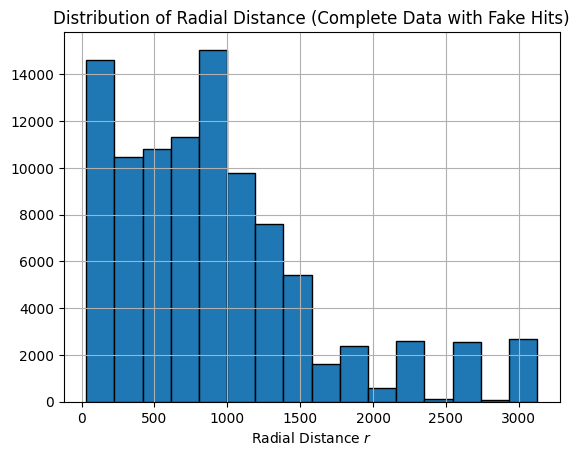

In [11]:
plt.hist( spatial_data['r'] , bins = 16 , edgecolor = 'k') 
plt.grid()
plt.xlabel(r'Radial Distance $r$')
plt.title('Distribution of Radial Distance (Complete Data with Fake Hits)'); 

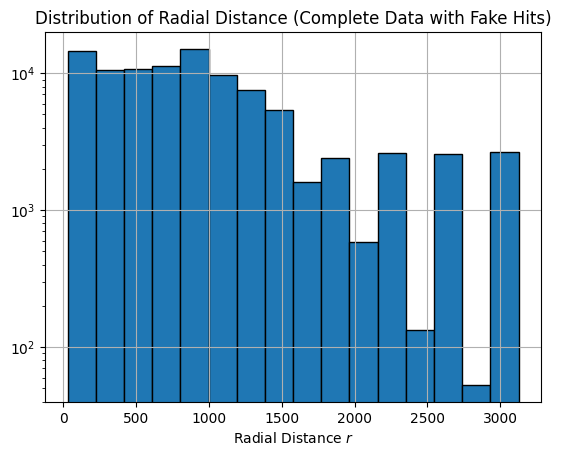

In [12]:
plt.hist( spatial_data['r'] , bins = 16 , edgecolor = 'k') 
plt.grid()
plt.semilogy()
plt.xlabel(r'Radial Distance $r$')
plt.title('Distribution of Radial Distance (Complete Data with Fake Hits)'); 

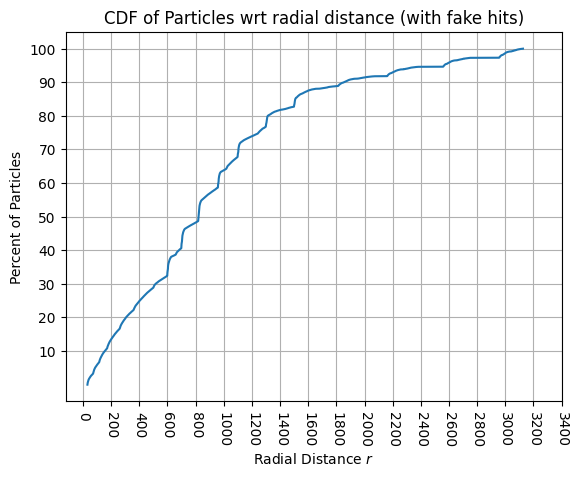

In [13]:
# analyise the cumilative distribution function : 
radius_data = spatial_data['r'] 
radius_data = np.sort( radius_data )

# total number of particles : 
n = radius_data.shape[0] 

num_parts = np.arange( 1 , n + 1  )
percent_parts = num_parts*100/n  

plt.plot(radius_data , percent_parts ) 
plt.yticks([10*i for i in range(1,11)])
plt.title('CDF of Particles wrt radial distance (with fake hits)')
plt.ylabel('Percent of Particles')
plt.xlabel(r'Radial Distance $r$')
plt.xticks([200*i for i in range(0 , 18 )] , rotation = -90 )
plt.grid(); 

#### 1b. Excluding Fake Hits 

In [14]:
fake_hits_mask = labels == 0 
print('Percent of Fake Hits in Total {:.4f} %'.format(np.sum(fake_hits_mask)*100/n))

Percent of Fake Hits in Total 18.8149 %


note that fake hits represent about one fifth of the complete hits per event, hence it is important to deal with them properlly

In [15]:
filtered_spatial_data = spatial_data[~fake_hits_mask]
filtered_spatial_data.shape 

(79330, 4)

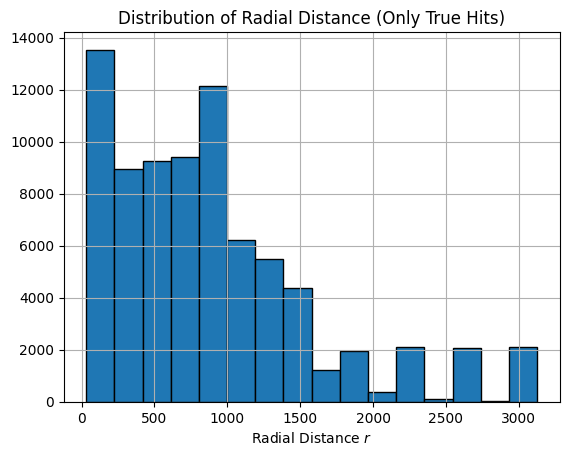

In [16]:
plt.hist( filtered_spatial_data['r'] , bins = 16 , edgecolor = 'k') 
plt.grid()
plt.xlabel(r'Radial Distance $r$')
plt.title('Distribution of Radial Distance (Only True Hits)'); 

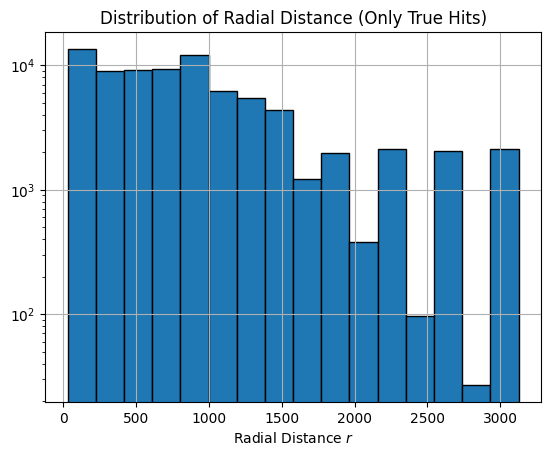

In [17]:
plt.hist( filtered_spatial_data['r'] , bins = 16 , edgecolor = 'k') 
plt.grid()
plt.semilogy()
plt.xlabel(r'Radial Distance $r$')
plt.title('Distribution of Radial Distance (Only True Hits)'); 

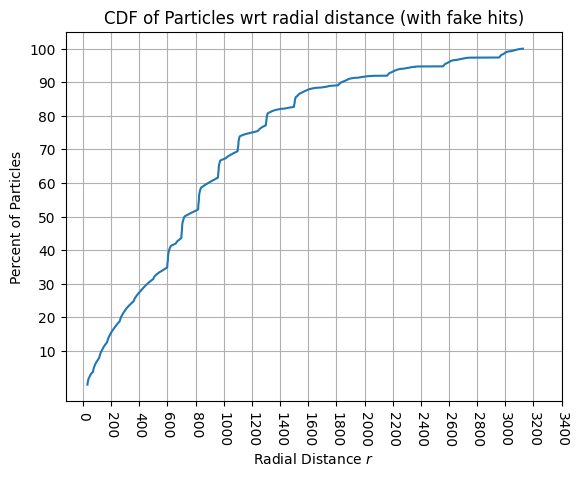

In [18]:
# analyise the cumilative distribution function : 
radius_data = filtered_spatial_data['r'] 
radius_data = np.sort( radius_data )

# total number of particles : 
n = radius_data.shape[0] 

num_parts = np.arange( 1 , n + 1  )
percent_parts = num_parts*100/n  

plt.plot(radius_data , percent_parts ) 
plt.yticks([10*i for i in range(1,11)])
plt.title('CDF of Particles wrt radial distance (with fake hits)')
plt.ylabel('Percent of Particles')
plt.xlabel(r'Radial Distance $r$')
plt.xticks([200*i for i in range(0 , 18 )] , rotation = -90 )
plt.grid(); 

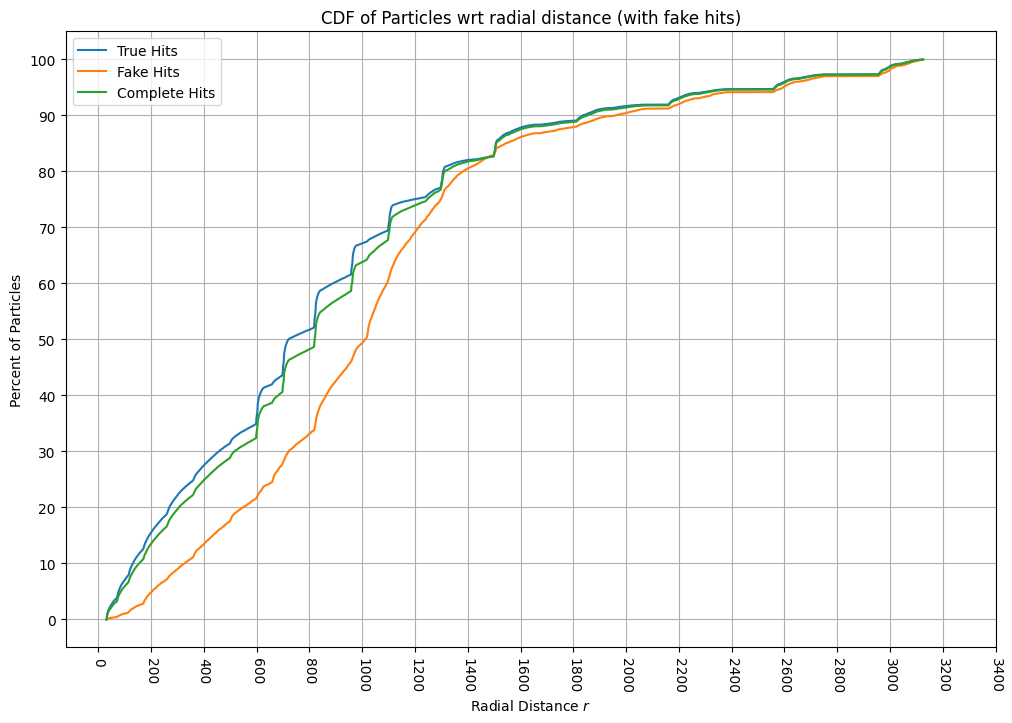

In [19]:
# analyise the cumilative distribution function : 
radius_data_complete = spatial_data['r']
radius_data_complete = np.sort( radius_data_complete )

radius_data_true = filtered_spatial_data['r'] 
radius_data_true = np.sort( radius_data_true )

radius_data_fake = spatial_data[fake_hits_mask]['r'] 
radius_data_fake = np.sort( radius_data_fake )

# total number of particles : 
n_true = radius_data_true.shape[0] 
n_fake = radius_data_fake.shape[0]
n_complete = radius_data_complete.shape[0]

percent_parts_true =  np.arange( 1 , n_true + 1  )*100/n_true 
percent_parts_fake = np.arange( 1 , n_fake + 1 )*100/n_fake
percent_parts_complete = np.arange( 1 , n_complete + 1 )*100/n_complete 

plt.figure( figsize=(12,8))
plt.plot(radius_data_true , percent_parts_true , label = 'True Hits') 
plt.plot(radius_data_fake , percent_parts_fake , label = 'Fake Hits') 
plt.plot(radius_data_complete , percent_parts_complete , label = 'Complete Hits')
plt.yticks([10*i for i in range(0,11)])
plt.title('CDF of Particles wrt radial distance (with fake hits)')
plt.ylabel('Percent of Particles')
plt.xlabel(r'Radial Distance $r$')
plt.xticks([200*i for i in range(0 , 18 )] , rotation = -90 )
plt.legend()
plt.grid(); 

In [20]:
# filter out particles with radial size grater than 1000 cm. 

## 2. Analysis of Fake Particle Distribution in the data 

It is important for the underlying distribution of the fake hits to be different so as to make it possible for our model to differenciate true hits from the fake ones 

#### 2a. Principal Component Analysis 

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [22]:
np_event_data = event_data.to_numpy()[ :  , 1: ]

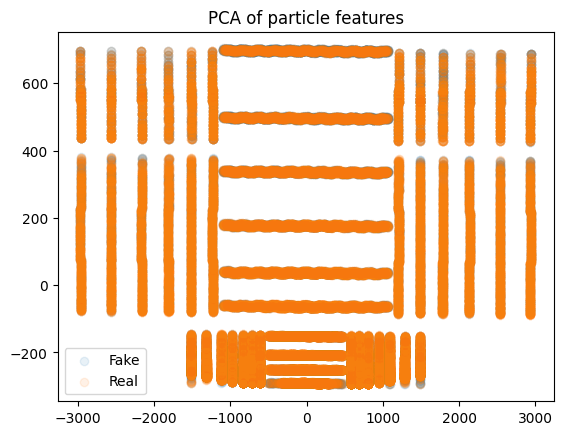

In [23]:
pca = PCA(n_components=2)
X_proj = pca.fit_transform(np_event_data)  # X = your 15-feature data
plt.scatter(X_proj[fake_hits_mask, 0], X_proj[fake_hits_mask, 1], label='Fake', alpha=0.1)
plt.scatter(X_proj[~fake_hits_mask, 0], X_proj[~fake_hits_mask, 1], label='Real', alpha=0.1)
plt.legend()
plt.title('PCA of particle features')
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [25]:
X_combined = np.vstack([np_event_data[~fake_hits_mask], np_event_data[fake_hits_mask]])
y_labels = np.array([0]*len(np_event_data[~fake_hits_mask]) + [1]*len(np_event_data[fake_hits_mask]))

clf = RandomForestClassifier()
score = cross_val_score(clf, X_combined, y_labels, cv=5).mean()
print(f"Accuracy = {score:.2f}")

Accuracy = 0.22


With the current feature engineering, there is no way to tell the real and fake particles apart. 